(1) Synthetically create some Z sequences

(2) With some randomly initialized mlp decoder ,  set Z’=inv_mlp(mlp(Z)
Train both mlp and inv_mlp by reducing the  reconstruction loss |Z’-Z|

(3) Generate seqs using the trained mlp : X =mlp(Z)

(4) Train Seq AE on this  on X

In [21]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from datasets import so3_data as so3d
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from models import base_networks as bn
from utils import optimize_bd_cob as obc
from importlib import reload
import copy
reload(bn)

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

    
    
from utils import yaml_utils as yu
import yaml
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'

rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
datpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/so3'






In [22]:
os.listdir(datpath)

['so3dat_sphere_MLP.pt',
 'so3dat_sphere_Linear_model.pt',
 'so3dat_sphere_iResNet_shared_trans.pt',
 'so3dat_sphere_sine_shared_trans.pt',
 'so3dat_sphere_iResNet_model.pt',
 'so3dat_sphere_MLP_shared_trans.pt',
 'so3dat_sphere_Identity_model.pt',
 'so3dat_sphere_sine.pt',
 'so3dat_sphere_Linear_model_invhat.pt',
 'so3dat_sphere_Identity.pt',
 'so3dat_sphere_iResNet.pt',
 'so3dat_sphere_MLP_model.pt',
 'so3dat_sphere_Linear.pt',
 'so3dat_sphere_MLP_model_invhat.pt',
 'so3dat_sphere_Linear_shared_trans.pt',
 'so3dat_sphere_sine_model.pkl']

In [46]:
reload(bn)
embed_fxn_mode = 'sine'
modelmode = 'so3'
num_blocks = 2
tensor_dim = 10 

modelpath = f"""{modelmode}dat_sphere_{embed_fxn_mode}_model.pt"""
datapath = f"""{modelmode}dat_sphere_{embed_fxn_mode}.pt"""

dataconfig = {'args': {'T': 8, 'data_filename': f"""{modelmode}dat_sphere_{embed_fxn_mode}.pt""", 'train': True},
 'fn': './datasets/so3_data.py',
 'name': 'SO3rotationSequence'}

modelconfig = {'args': {'ch_x': 1, 'dim_a': 6, 'dim_m': 10, 'k': 2.0, 'predictive': True},
 'fn': './models/seqae.py',
 'name': f"""SeqAELSTSQ_{modelmode}Net"""}

data = yu.load_component(dataconfig)
datafile = torch.load(os.path.join(datpath, datapath))


initmode ='cond'
dospec = False
hidden_m = 6
nlayer = 5

if embed_fxn_mode == 'iResNet':
    embed_fxn = bn.MLP_iResNet(in_dim=3*num_blocks*tensor_dim)
    inv_fxn = bn.MLP_iResNet(in_dim=3*num_blocks*tensor_dim)

elif embed_fxn_mode == 'Linear':
    indim= 3 * num_blocks*tensor_dim
    outdim = 3 * num_blocks*tensor_dim
    embed_fxn = bn.LinearNet(in_dim=indim, out_dim=outdim)
    inv_fxn = bn.LinearNet(in_dim=indim, out_dim=outdim)
    mylr = 0.01

elif embed_fxn_mode == 'MLP':
    indim= 3 * num_blocks*tensor_dim
    outdim = 3 * num_blocks*tensor_dim
    embed_fxn = bn.MLP(in_dim=indim, out_dim=outdim, hidden_multiple=hidden_m, initmode=initmode, num_layer=nlayer, dospec=dospec)
    inv_fxn = bn.MLP(in_dim=indim, out_dim=outdim, hidden_multiple=hidden_m,  initmode=initmode, num_layer=nlayer, dospec=dospec)
    mylr = 0.01
    
elif embed_fxn_mode == 'sine':
    indim= 3 * num_blocks*tensor_dim
    outdim = 3 * num_blocks*tensor_dim
    embed_fxn = bn.Radial_sine()
    inv_fxn = bn.MLP(in_dim=indim, out_dim=outdim, hidden_multiple=hidden_m,  initmode=initmode, num_layer=nlayer, dospec=dospec)
    #inv_fxn = bn.MLP_iResNet(in_dim=3*num_blocks*tensor_dim)
    mylr = 0.01
    
else:
    raise NotImplementedError

# model_dict = torch.load(os.path.join(datpath, modelpath))
# embed_fxn.load_state_dict(model_dict, strict=False)









condition passed
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
initializing loop
condition passed
condition passed
initializing loop
initializing loop
initializing loop
condition passed
initializing loop
initializing loop
initializing loop
initializing loop
condition passed


In [47]:
datpath, datapath

('/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/so3',
 'so3dat_sphere_sine.pt')

In [48]:
latent = datafile['latent']
print(latent.shape)
latent_inform = rearrange(latent, 'n t a m -> (n t) (a m)')
print(latent_inform.shape)

torch.Size([10000, 15, 10, 6])
torch.Size([150000, 60])


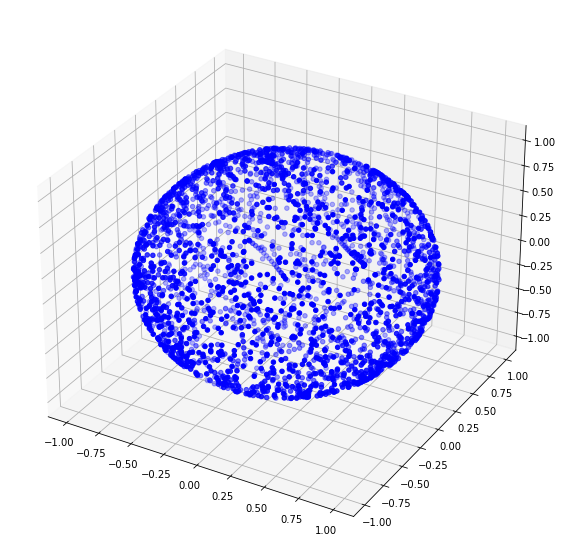

In [49]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
import colorsys


myslice = 4
pos= 1

shift= 0
for k in range(200):
    dat = latent[shift+k, :, myslice, pos*3:(pos+1)*3]
    ax.scatter(dat[:, 0], dat[:, 1], dat[:, 2], color= 'blue')



In [50]:
embed_fxn

Radial_sine()

In [51]:
latent.shape

torch.Size([10000, 15, 10, 6])

In [53]:
device =  'cpu'

dec_hat = copy.deepcopy(embed_fxn).to(device)
enc_hat = copy.deepcopy(inv_fxn).to(device)

dataloader = DataLoader(
        latent.detach(), batch_size=20, shuffle=False,
        num_workers=2)

#paramset = list(dec_hat.parameters()) + list(enc_hat.parameters())
paramset = list(enc_hat.parameters())


mylr = 0.001
optimizer = torch.optim.Adam(paramset, lr=mylr)
freq =1
num_epoch=30

for epoch in range(num_epoch):
    rec_loss_total = 0 
    for latent_b in tqdm(dataloader):
        latent_b = latent_b.to(device).float()
        latent_b = rearrange(latent_b, 'n t s a -> (n t)(s a)') 
        optimizer.zero_grad()
        
        rec_loss = torch.sum((latent_b - enc_hat(dec_hat(latent_b)))**2  )
        rec_loss.backward()
        optimizer.step()
        rec_loss_total = rec_loss_total + rec_loss.detach()
    rec_loss_mean = rec_loss_total/len(dataloader.dataset)
    if epoch % freq == 0:
        print(f"""Epoch {epoch} :  loss {rec_loss_mean}""")
        
    
    

100%|██████████| 500/500 [00:08<00:00, 57.26it/s]


Epoch 0 :  loss 24.330123901367188


100%|██████████| 500/500 [00:09<00:00, 55.18it/s]


Epoch 1 :  loss 13.521395683288574


100%|██████████| 500/500 [00:07<00:00, 65.77it/s]


Epoch 2 :  loss 12.666426658630371


100%|██████████| 500/500 [00:07<00:00, 68.62it/s]


Epoch 3 :  loss 12.416864395141602


100%|██████████| 500/500 [00:07<00:00, 68.19it/s]


Epoch 4 :  loss 12.273079872131348


100%|██████████| 500/500 [00:07<00:00, 67.66it/s]


Epoch 5 :  loss 12.096622467041016


100%|██████████| 500/500 [00:08<00:00, 61.43it/s]


Epoch 6 :  loss 11.824429512023926


100%|██████████| 500/500 [00:08<00:00, 55.84it/s]


Epoch 7 :  loss 11.374195098876953


100%|██████████| 500/500 [00:08<00:00, 59.58it/s]


Epoch 8 :  loss 10.639914512634277


100%|██████████| 500/500 [00:08<00:00, 59.13it/s]


Epoch 9 :  loss 9.544973373413086


100%|██████████| 500/500 [00:08<00:00, 58.13it/s]


Epoch 10 :  loss 8.068231582641602


100%|██████████| 500/500 [00:08<00:00, 59.13it/s]


Epoch 11 :  loss 6.4092583656311035


100%|██████████| 500/500 [00:08<00:00, 58.63it/s]


Epoch 12 :  loss 4.996985912322998


100%|██████████| 500/500 [00:08<00:00, 58.45it/s]


Epoch 13 :  loss 4.009961128234863


100%|██████████| 500/500 [00:08<00:00, 58.64it/s]


Epoch 14 :  loss 3.374131679534912


100%|██████████| 500/500 [00:08<00:00, 57.81it/s]


Epoch 15 :  loss 2.939300298690796


100%|██████████| 500/500 [00:08<00:00, 59.33it/s]


Epoch 16 :  loss 2.647559404373169


100%|██████████| 500/500 [00:09<00:00, 54.57it/s]


Epoch 17 :  loss 2.4337964057922363


100%|██████████| 500/500 [00:08<00:00, 57.51it/s]


Epoch 18 :  loss 2.2718374729156494


100%|██████████| 500/500 [00:08<00:00, 57.36it/s]


Epoch 19 :  loss 2.1423916816711426


100%|██████████| 500/500 [00:08<00:00, 59.33it/s]


Epoch 20 :  loss 2.022437810897827


100%|██████████| 500/500 [00:08<00:00, 61.19it/s]


Epoch 21 :  loss 1.9204462766647339


100%|██████████| 500/500 [00:07<00:00, 68.32it/s]


Epoch 22 :  loss 1.8255048990249634


100%|██████████| 500/500 [00:07<00:00, 67.63it/s]


Epoch 23 :  loss 1.7425947189331055


100%|██████████| 500/500 [00:07<00:00, 66.74it/s]


Epoch 24 :  loss 1.6658122539520264


100%|██████████| 500/500 [00:07<00:00, 65.17it/s]


Epoch 25 :  loss 1.5965903997421265


100%|██████████| 500/500 [00:08<00:00, 59.13it/s]


Epoch 26 :  loss 1.5018284320831299


100%|██████████| 500/500 [00:08<00:00, 58.16it/s]


Epoch 27 :  loss 1.4395675659179688


100%|██████████| 500/500 [00:07<00:00, 65.00it/s]


Epoch 28 :  loss 1.3604024648666382


100%|██████████| 500/500 [00:08<00:00, 58.56it/s]

Epoch 29 :  loss 1.3022316694259644


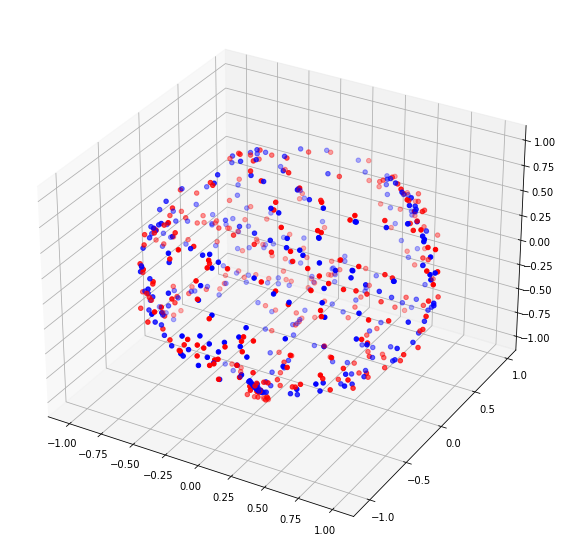

In [56]:
latent_input = copy.deepcopy(rearrange(latent, 'n t s a -> (n t)(s a)'))
latent_hat = enc_hat(dec_hat(latent_input)).reshape([len(latent), -1, tensor_dim, 3*num_blocks]).detach()




fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
import colorsys


myslice = 0
pos= 1

shift= 7
for k in range(20):
    dat = latent[shift+k, :, myslice, pos*3:(pos+1)*3]
    dathat = latent_hat[shift+k, :, myslice, pos*3:(pos+1)*3]
    ax.scatter(dat[:, 0], dat[:, 1], dat[:, 2], color= 'blue')
    ax.scatter(dathat[:, 0], dathat[:, 1], dathat[:, 2], color= 'red')





In [57]:
enc_hat

MLP(
  (network): Sequential(
    (0): Linear(in_features=60, out_features=360, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=360, out_features=360, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=360, out_features=360, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=360, out_features=360, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=360, out_features=360, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=360, out_features=60, bias=True)
  )
)

In [59]:
modelpath = os.path.join(datpath, 'so3dat_sphere_sin_model_invhat.pt')

torch.save(enc_hat.state_dict(), modelpath)


# Linear Reconstructability

In [60]:
latent_input = rearrange(latent, 'n t s a -> (n t)(s a)') 
new_xdat = dec_hat(latent_input)

In [61]:
indim= 3 * num_blocks*tensor_dim
outdim = 3 * num_blocks*tensor_dim

enc_est = bn.LinearNet(in_dim=indim, out_dim=outdim)
dec_est = bn.LinearNet(in_dim=indim, out_dim=outdim)

dec_hat = dec_hat.eval()
enc_hat = enc_hat.eval()


# dec_est = MLP(in_dim=indim, out_dim=outdim)
# enc_est = MLP(in_dim=indim, out_dim=outdim)
dec_est

LinearNet(
  (network): Linear(in_features=60, out_features=60, bias=True)
)

In [62]:
dec_hat

Radial_sine()

In [64]:
device = 'cpu'


dataloader = DataLoader(
        latent.detach(), batch_size=10, shuffle=False,
        num_workers=2)

paramset = list(dec_est.parameters()) + list(enc_est.parameters())
mylr = 0.001
optimizer = torch.optim.Adam(paramset, lr=mylr)
freq =1
num_epoch=20

for epoch in range(num_epoch):
    rec_loss_total = 0 
    for latent_b in tqdm(dataloader):
        latent_b = latent_b.to(device).float()
        latent_b = rearrange(latent_b, 'n t s a -> (n t)(s a)') 
        optimizer.zero_grad()
        
        rec_loss = torch.sum((dec_hat(latent_b) - dec_est(latent_b))**2)
        rec_loss.backward()
        optimizer.step()
        rec_loss_total = rec_loss_total + rec_loss.detach()
    rec_loss_mean = rec_loss_total/len(dataloader.dataset)
    if epoch % freq == 0:
        print(f"""Epoch {epoch} :  loss {rec_loss_mean}""")
        
    
    

100%|██████████| 1000/1000 [00:02<00:00, 381.01it/s]


Epoch 0 :  loss 75.01053619384766


100%|██████████| 1000/1000 [00:02<00:00, 492.62it/s]


Epoch 1 :  loss 75.00556945800781


100%|██████████| 1000/1000 [00:02<00:00, 494.34it/s]


Epoch 2 :  loss 75.00558471679688


100%|██████████| 1000/1000 [00:02<00:00, 451.40it/s]


Epoch 3 :  loss 75.00559997558594


100%|██████████| 1000/1000 [00:02<00:00, 396.99it/s]


Epoch 4 :  loss 75.00560760498047


100%|██████████| 1000/1000 [00:02<00:00, 406.92it/s]


Epoch 5 :  loss 75.00560760498047


100%|██████████| 1000/1000 [00:02<00:00, 419.06it/s]


Epoch 6 :  loss 75.00560760498047


100%|██████████| 1000/1000 [00:02<00:00, 399.69it/s]


Epoch 7 :  loss 75.00560760498047


100%|██████████| 1000/1000 [00:02<00:00, 410.05it/s]


Epoch 8 :  loss 75.00560760498047


100%|██████████| 1000/1000 [00:02<00:00, 380.30it/s]


Epoch 9 :  loss 75.00560760498047


100%|██████████| 1000/1000 [00:02<00:00, 398.13it/s]


Epoch 10 :  loss 75.00560760498047


100%|██████████| 1000/1000 [00:02<00:00, 347.83it/s]


Epoch 11 :  loss 75.00560760498047


 75%|███████▌  | 751/1000 [00:01<00:00, 390.32it/s]


KeyboardInterrupt: 

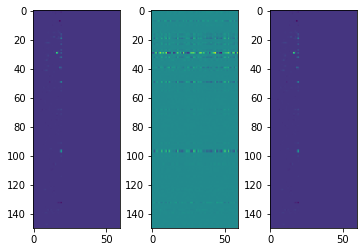

In [27]:
plt.subplot(131)
plt.imshow(dec_hat(latent_b).detach())
plt.subplot(132)
plt.imshow(dec_est(latent_b).detach())
plt.subplot(133)
plt.imshow(latent_b.detach())

In [28]:
dec_hat(latent_b)

tensor([[-4.3097e+03,  4.7976e+09, -1.4786e+13,  ...,  8.2585e-02,
          3.4710e-01,  9.3419e-01],
        [ 2.0714e+02, -5.7954e+08,  4.2723e+10,  ..., -1.1411e-01,
          5.4607e-01,  8.2993e-01],
        [ 1.5073e+03, -2.4034e+09,  1.2450e+10,  ..., -1.3846e-01,
          7.6526e-01,  6.2865e-01],
        ...,
        [-8.3461e+01,  3.9814e+03, -1.4879e+06,  ...,  6.7452e-01,
          3.2075e-01,  6.6494e-01],
        [-2.4563e+02, -9.0370e+03,  4.5286e+04,  ...,  3.4501e-01,
          6.0435e-01,  7.1814e-01],
        [-1.2948e+02,  3.8467e+06,  2.7452e+09,  ...,  1.3805e-01,
          8.8220e-01,  4.5018e-01]])

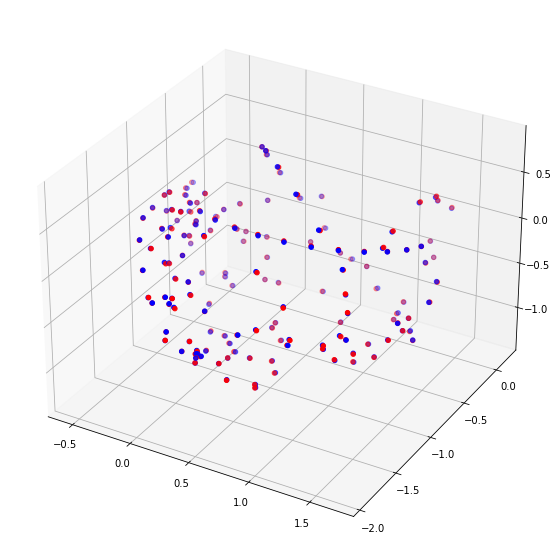

In [159]:
latent_input = rearrange(latent, 'n t b a -> (n t) (b a)')
dat_hat_hat = dec_est(latent_input).detach()
dat_hat = dec_hat(latent_input).detach()

dat_hat_hat = dat_hat_hat.reshape([-1, 15, 10, 6])
dat_hat = dat_hat.reshape([-1, 15, 10, 6])





fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
import colorsys


myslice = 0
pos= 1

shift= 0
for k in range(10):

    dathat_b = dat_hat[shift+k, :, myslice, pos*3:(pos+1)*3]
    dathathat_b = dat_hat_hat[shift+k, :, myslice, pos*3:(pos+1)*3]
    
    ax.scatter(dathat_b[:, 0], dathat_b[:, 1], dathat_b[:, 2], color= 'blue')
    ax.scatter(dathathat_b[:, 0], dathathat_b[:, 1], dathathat_b[:, 2], color= 'red')









torch.Size([10, 15, 10, 6])

In [17]:
dataloader = DataLoader(
        latent.detach(), batch_size=10, shuffle=False,
        num_workers=2)

paramset = list(dec_est.parameters()) + list(enc_est.parameters())
mylr = 0.001
optimizer = torch.optim.Adam(paramset, lr=mylr)
freq =5
num_epoch=10

for epoch in range(num_epoch):
    rec_loss_total = 0 
    for latent_b in tqdm(dataloader):
        latent_b = latent_b.to(device).float()
        latent_b = rearrange(latent_b, 'n t s a -> (n t)(s a)') 
        optimizer.zero_grad()
        
        rec_loss = torch.sum((latent_b - enc_est(dec_hat(latent_b)))**2) 
        rec_loss.backward()
        optimizer.step()
        rec_loss_total = rec_loss_total + rec_loss.detach()
    rec_loss_mean = rec_loss_total/len(dataloader.dataset)
    if epoch % freq == 0:
        print(f"""Epoch {epoch} :  loss {rec_loss_mean}""")

100%|██████████| 1000/1000 [00:04<00:00, 229.33it/s]


Epoch 0 :  loss 198.62799072265625


 26%|██▌       | 258/1000 [00:01<00:03, 201.40it/s]


KeyboardInterrupt: 

In [17]:
rec_loss_mean

tensor(0.0246)

In [18]:
enc_est

LinearNet(
  (network): Linear(in_features=60, out_features=60, bias=True)
)

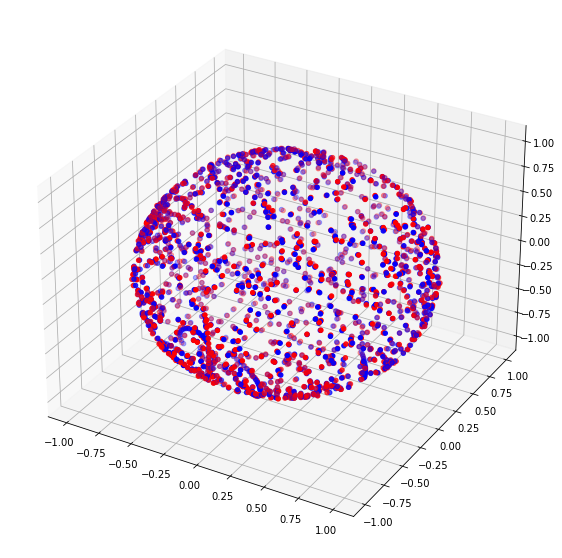

In [19]:
latent_input = rearrange(latent, 'n t s a -> (n t)(s a)') 
latent_hat_hat = enc_est(dec_hat(latent_input)).reshape([len(latent), -1, tensor_dim, 3*num_blocks]).detach()




fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
import colorsys


myslice = 0
pos= 1

shift= 0
for k in range(100):
    dat = latent[shift+k, :, myslice, pos*3:(pos+1)*3]
    dathathat = latent_hat_hat[shift+k, :, myslice, pos*3:(pos+1)*3]
    ax.scatter(dat[:, 0], dat[:, 1], dat[:, 2], color= 'blue')
    ax.scatter(dathathat[:, 0], dathathat[:, 1], dathathat[:, 2], color= 'red')






In [20]:
enc_hat

MLP(
  (network): Sequential(
    (0): Linear(in_features=60, out_features=300, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=300, out_features=300, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=300, out_features=60, bias=True)
  )
)

In [21]:
dat_obs = dec_hat(latent_input)

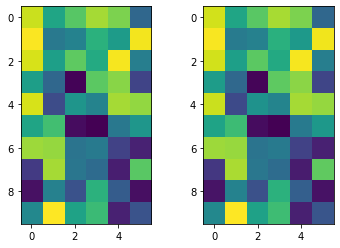

In [28]:
plt.subplot(122)
plt.imshow(enc_est(dat_obs[0]).detach().reshape([10, 6]))
plt.subplot(121)
plt.imshow(enc_hat(dat_obs[0]).detach().reshape([10, 6]))





In [31]:
M = torch.tensor(np.random.normal(size=(3,3)))
P = torch.tensor(np.random.normal(size=(3,3)))

unko = torch.linalg.solve(P, M@P)
unko

tensor([[-0.3002,  0.2130, -0.4965],
        [ 3.2442, -0.4151,  1.5165],
        [-1.0633,  0.4787, -0.9802]], dtype=torch.float64)

In [32]:
torch.linalg.inv(P) @ M @ P 

tensor([[-0.3002,  0.2130, -0.4965],
        [ 3.2442, -0.4151,  1.5165],
        [-1.0633,  0.4787, -0.9802]], dtype=torch.float64)

In [39]:
np.random.normal(size =unko.shape)

array([[ 1.54143531,  0.85622424,  0.27888324],
       [-1.28340759, -0.29612076, -0.82298239],
       [ 0.29960278, -0.36423545, -0.23047898]])

In [40]:
unko.shape[0]

3

In [43]:
prompt()

enter aaaa y/n y
xxX


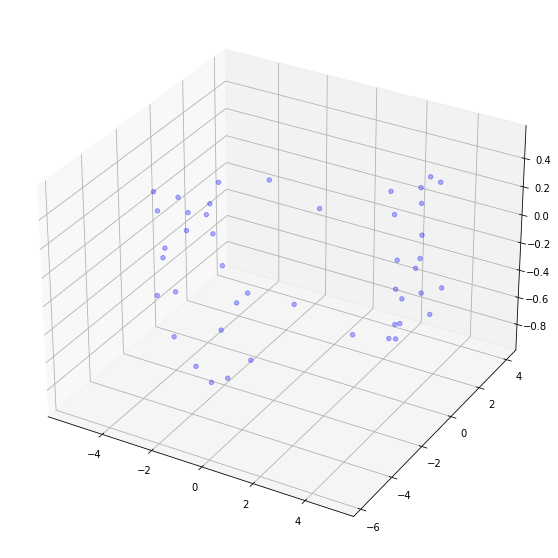

In [121]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
import colorsys


myslice = 0
pos= 1
freq=5.

shift= 0
for k in range(3):
    dat = latent[shift+k, :, myslice, pos*3:(pos+1)*3]
    x = dat[:, 0]
    y = dat[:, 1]
    z = dat[:, 2]
    
    rad = freq * np.arctan(x / y)


    radx = freq * np.arctan(z / x)
    rady = freq * np.arctan(z / y)


    
    #rad_dis = (0.5* np.sin(radx) * np.sin(rady) + 2.)
    rad_dis = (1.0* np.sin(rad) + 2.)



    
    x = x * (rad_dis +  3)
    y = y * (rad_dis  + 3)
    z = z

    ax.scatter(x, y, z, color= 'blue', alpha=0.3)




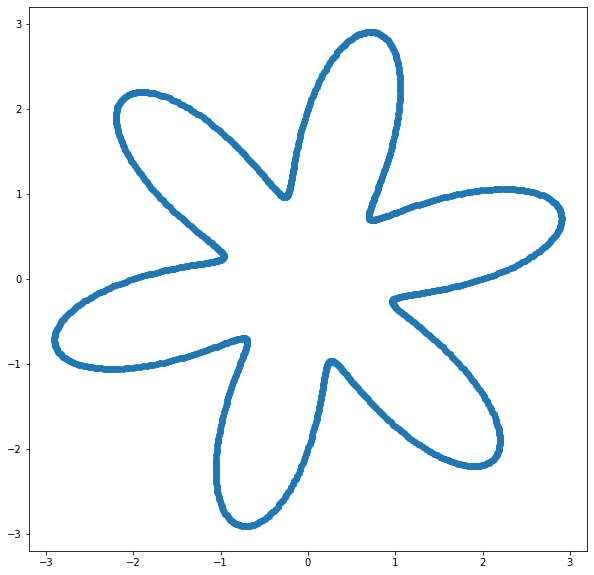

In [117]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
import colorsys


checkX = np.sin(np.linspace(0, 2* np.pi,1000))

checkY = np.cos(np.linspace(0, 2* np.pi,1000))

freq = 6

rad = freq * np.arctan(checkX / checkY)
rad_dis = (1.0* np.sin(rad) + 2.)

x = rad_dis * checkX 
y = rad_dis * checkY 

ax.scatter(x,y)

In [22]:
numseq=1000
lenseq=15


checkX = torch.tensor(np.sin(np.linspace(0, 2* np.pi, numseq*lenseq)))
checkY = torch.tensor(np.cos(np.linspace(0, 2* np.pi, numseq*lenseq)))
checkZ = torch.zeros(checkX.shape)

In [37]:
check_dat  = torch.stack([checkX, checkY, checkZ])
check_dat  = torch.cat([check_dat, check_dat])
check_dat = check_dat.permute([1,0])
print(check_dat.shape)

xdat = dec_hat(check_dat)




print(xdat[0])
print(check_dat[0])


torch.Size([15000, 6])
tensor([0.0000, 9.0000, 0.0000, 0.0000, 1.0000, 0.0000], dtype=torch.float64)
tensor([0., 1., 0., 0., 1., 0.], dtype=torch.float64)


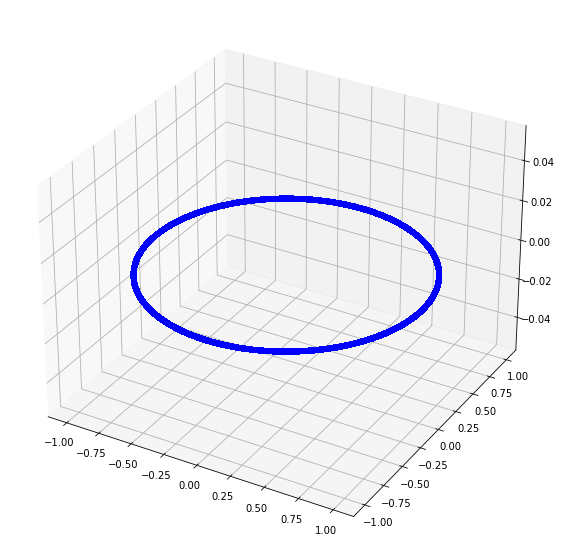

In [31]:

check_dat = check_dat.reshape(-1 , 10, 6)
xdat = xdat.reshape(-1 , 10, 6)


print(check_dat.shape)
print(xdat.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')




#check_dat = latent

myslice = 0
pos= 1

shift= 0
for k in range(200):

    batch = check_dat[:, myslice, pos*3:(pos+1)*3]
    xbatch = xdat[:, myslice, pos*3:(pos+1)*3]


    
    ax.scatter(batch[:, 0], batch[:, 1], batch[:, 2], color= 'blue')

    ax.scatter(xbatch[:, 0], xbatch[:, 1], xbatch[:, 2], color= 'red')








In [32]:
xbatch 

tensor([[ 0.0000,  1.0000,  0.0000],
        [ 0.0042,  1.0000,  0.0000],
        [ 0.0084,  1.0000,  0.0000],
        ...,
        [-0.0121,  0.9999,  0.0000],
        [-0.0080,  1.0000,  0.0000],
        [-0.0038,  1.0000,  0.0000]], dtype=torch.float64)

In [33]:
batch

tensor([[ 0.0000,  1.0000,  0.0000],
        [ 0.0042,  1.0000,  0.0000],
        [ 0.0084,  1.0000,  0.0000],
        ...,
        [-0.0121,  0.9999,  0.0000],
        [-0.0080,  1.0000,  0.0000],
        [-0.0038,  1.0000,  0.0000]], dtype=torch.float64)

In [69]:
unko = torch.tensor([[1, 1], [1, -1]]).float()

In [70]:
torch.linalg.inv(unko)

tensor([[ 0.5000,  0.5000],
        [ 0.5000, -0.5000]])